In [114]:
from music21 import converter, instrument, note, chord, stream
import numpy
from matplotlib import pyplot as plt
import keras
import pandas as pd

In [26]:
midi = converter.parse("pathetique_3.mid")
midi

<music21.stream.Score 0x7a6d0623a6e0>

In [33]:
print(len(midi.flatten().notes))

2117


In [ ]:
for element in midi.flatten().notes:
  if isinstance(element , note.Note):
    print(element , element.offset, element.pitch)
  if isinstance(element, chord.Chord):
     print(element, element.offset, '+'.join(str(n) for n in element.normalOrder))


In [59]:
notes = []

for element in midi.flatten().notes:
  if isinstance(element , note.Note):
    notes.append((float(element.offset), float(element.seconds), str(element.pitch)))
  if isinstance(element, chord.Chord):
     notes.append((float(element.offset), float(element.seconds), '+'.join(str(n) for n in element.normalOrder)))


In [63]:
unique_notes = set(item for item in notes)
print(len(notes))
print(len(unique_notes))

2117
2115


In [95]:
note_dict = dict((note, number) for number, note in enumerate(unique_notes))

In [96]:
note_dict

{(354.0, 0.6381281574049454, 'E-5'): 0,
 (134.0, 0.6084884133664621, '3+6+10'): 1,
 (839.0, 0.09756097560975609, 'D5'): 2,
 (568.0, 0.2906835909112931, '2+5'): 3,
 (235.66666666666666, 0.10327377878756584, 'C6'): 4,
 (437.5, 0.07249879168680522, 'D3'): 5,
 (282.0, 0.14431402732345586, 'F3'): 6,
 (422.5, 0.14776869273963156, 'G3'): 7,
 (505.0, 0.14682131845543972, 'C4'): 8,
 (299.5, 0.14493453790038166, 'F4'): 9,
 (226.0, 0.5730385368416026, 'G#2'): 10,
 (290.5, 0.14609915262491477, 'G3'): 11,
 (598.3333333333334, 0.09550642280693375, 'E5'): 12,
 (252.5, 0.14493453790038166, 'E-3'): 13,
 (342.0, 0.3190640787024727, 'G2'): 14,
 (582.3333333333334, 0.09550642280693375, 'B4'): 15,
 (757.0, 0.09569377990430622, 'E-4'): 16,
 (511.5, 0.14993253036133738, 'E-5'): 17,
 (568.0, 0.14534179545564654, 'E5'): 18,
 (309.75, 0.0762582613116421, 'D5'): 19,
 (130.5, 0.1453840562151684, 'A3'): 20,
 (632.0, 0.15739769150052466, '11+2'): 21,
 (562.0, 0.30112923462986196, 'C5'): 22,
 (88.0, 1.17457054764351

In [131]:
def check_pitch(x):
  if ('+' in x) or x.isdigit():
        notes_in_chord = x.split('+')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord =chord.Chord(notes).pitches[0].midi
        return new_chord
    # pattern is a note
  else:
        new_note = note.Note(x).pitch.midi
        return new_note

In [132]:
df = pd.DataFrame(notes, columns=['debut_note', 'durée(s)', 'pitch/chord'])
df['MIDI Pitch'] = df['pitch/chord'].apply(lambda x: check_pitch(x))




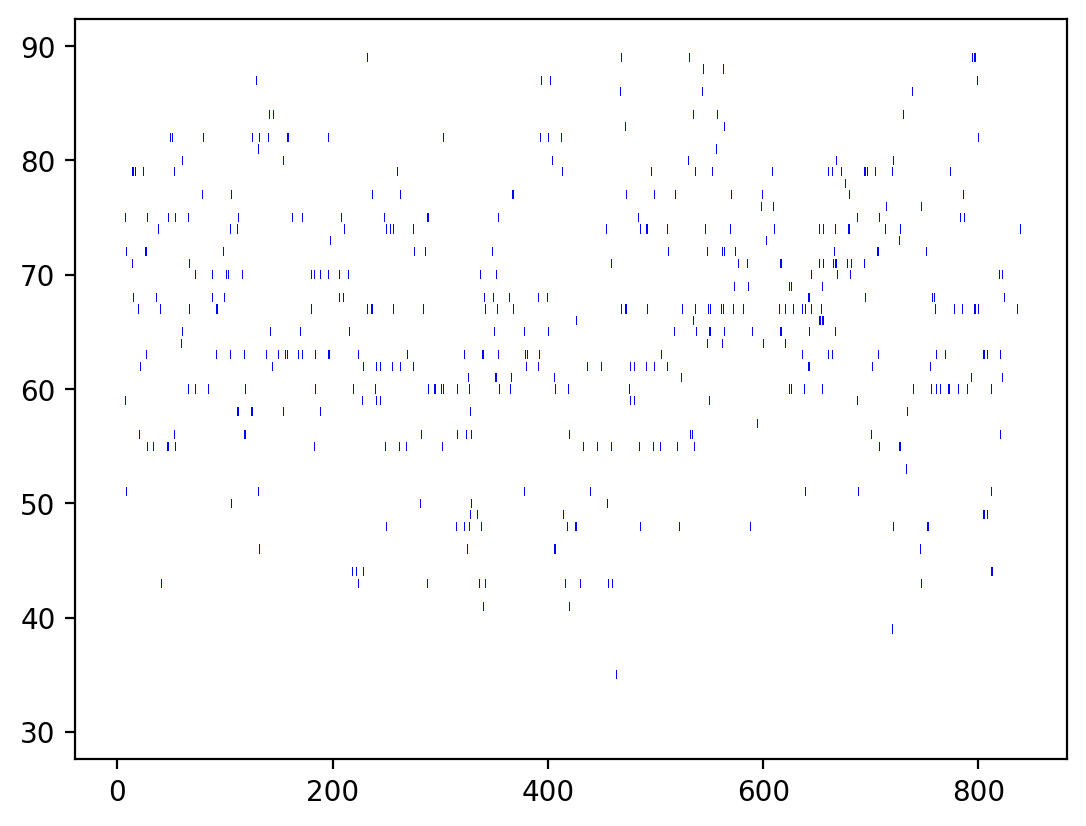

In [135]:
fig, ax = plt.subplots()

for index, row in df.iterrows():
    start = row['debut_note']
    duration = row['durée(s)']
    pitch = row['MIDI Pitch']

    ax.broken_barh([(float(start), float(duration))], (float(pitch) - 0.4, 0.8), facecolors='blue')


In [ ]:
plt.xlabel('Notes de piano')
ax.get_yaxis().set_visible(False)
plt.title('Clavier de piano avec des notes')

# Affichez le graphique
plt.show()

In [97]:
sequence_length = 100

network_input = []
network_output = []
# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_dict[char] for char in sequence_in])
    network_output.append(note_dict[sequence_out])
n_patterns = len(network_input)

In [ ]:
network_input

In [99]:
# reshape the input into a format compatible with LSTM layers
network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
# normalize input
network_input = network_input / float(len(set(notes)))
network_output = keras.utils.to_categorical(network_output)

In [109]:
from keras import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
model = Sequential()
model.add(LSTM(
        128,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        return_sequences=True
    ))
model.add(Dropout(0.3))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128))
model.add(Dense(128))
model.add(Dropout(0.3))
model.add(Dense(len(set(notes))))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [110]:
model.fit(network_input, network_output, epochs=200, batch_size=64)

Epoch 1/200
32/32 [==============================] - 17s 408ms/step - loss: 7.6637
Epoch 2/200
32/32 [==============================] - 14s 437ms/step - loss: 7.6597
Epoch 3/200
32/32 [==============================] - 13s 412ms/step - loss: 7.6586
Epoch 4/200
32/32 [==============================] - 13s 407ms/step - loss: 7.6575
Epoch 5/200
32/32 [==============================] - 13s 406ms/step - loss: 7.6568
Epoch 6/200
32/32 [==============================] - 13s 406ms/step - loss: 7.6561
Epoch 7/200
32/32 [==============================] - 13s 405ms/step - loss: 7.6549
Epoch 8/200
24/32 [=====================>........] - ETA: 3s - loss: 7.6533

KeyboardInterrupt: ignored

In [91]:
start = numpy.random.randint(0, len(network_input)-1)
int_to_note = dict((number, note) for number, note in enumerate(notes))
pattern = network_input[start]
prediction_output = []

In [ ]:
network_input

In [103]:
for note_index in range(500):
    prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(len(set(notes)))
    prediction = model.predict(prediction_input, verbose=0)
    index = numpy.argmax(prediction)
    result = int_to_note[index]
    prediction_output.append(result)
    pattern = np.append(pattern, index)
    pattern = pattern[1:len(pattern)]

In [106]:
prediction_output

[(760.6666666666666, 0.0954653937947494, 'D4'),
 (760.6666666666666, 0.0954653937947494, 'D4'),
 (760.6666666666666, 0.0954653937947494, 'D4'),
 (760.6666666666666, 0.0954653937947494, 'D4'),
 (760.6666666666666, 0.0954653937947494, 'D4'),
 (760.6666666666666, 0.0954653937947494, 'D4'),
 (760.6666666666666, 0.0954653937947494, 'D4'),
 (760.6666666666666, 0.0954653937947494, 'D4'),
 (760.6666666666666, 0.0954653937947494, 'D4'),
 (760.6666666666666, 0.0954653937947494, 'D4'),
 (760.6666666666666, 0.0954653937947494, 'D4'),
 (760.6666666666666, 0.0954653937947494, 'D4'),
 (760.6666666666666, 0.0954653937947494, 'D4'),
 (760.6666666666666, 0.0954653937947494, 'D4'),
 (760.6666666666666, 0.0954653937947494, 'D4'),
 (760.6666666666666, 0.0954653937947494, 'D4'),
 (760.6666666666666, 0.0954653937947494, 'D4'),
 (760.6666666666666, 0.0954653937947494, 'D4'),
 (760.6666666666666, 0.0954653937947494, 'D4'),
 (760.6666666666666, 0.0954653937947494, 'D4'),
 (760.6666666666666, 0.0954653937947494,

In [104]:
midi_stream = stream.Stream(prediction_output)
midi_stream.write('midi', fp='test_output.mid')

NameError: ignored